In [75]:
# Data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.utils import resample

# Feature selection
from sklearn.feature_selection import SelectKBest, f_classif

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Evaluation metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

# SHAP for model interpretation
import shap

# Configuration
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')


## research questions: 
1. How well does machine learning predict children’s happiness based on mobile phone usage and the level of attention in Burkina Faso?
2. What is the relationship between mobile phone usage and children’s attention levels in a context of how long they have had a mobile phone?

## Load data

In [76]:
df = pd.read_csv('BF_ML_ready.csv')

print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (672, 55)


,ID,Age,Class,Sex_binary,Attention_Score,Happiness_Score,PhoneUse_Score,A1,A2,A3,...,T12,T13,T14,school every day,share phone family,electricity at home,parents rules phone,Phone purpose,Phone_total_months,Has_phone
0,1,15,10,1,2.266667,3.166667,4.583333,1,4,1,...,4,0.0,4.0,0,0,1,0,Communication,4.0,1.0
1,2,14,10,0,3.000000,3.583333,4.250000,1,4,4,...,4,1.0,0.0,0,0,0,0,"School, Games",12.0,1.0
2,3,14,10,1,1.333333,3.000000,1.083333,1,1,1,...,1,0.0,0.0,0,0,0,0,Communication,0.0,0.0
3,4,15,10,1,2.000000,2.916667,3.916667,1,1,4,...,3,1.0,0.0,0,1,0,0,School,12.0,1.0
4,5,16,10,0,2.066667,2.666667,3.833333,3,3,1,...,2,16.0,0.0,0,0,1,0,Communication,192.0,1.0


## Data Preprocessing

In [77]:
# Drop individual happiness items, keeping only the average score
happiness_items = ['ID', 'H1', 'H2', 'H3', 'H4', 'H5', 'H6', 'H7', 'H8', 'H9', 'H10', 'H11', 'H12']
df.drop(columns=happiness_items, inplace=True, errors='ignore')

print(f"Dataset shape after dropping columns: {df.shape}")
df.head()

Dataset shape after dropping columns: (672, 42)


,Age,Class,Sex_binary,Attention_Score,Happiness_Score,PhoneUse_Score,A1,A2,A3,A4,...,T12,T13,T14,school every day,share phone family,electricity at home,parents rules phone,Phone purpose,Phone_total_months,Has_phone
0,15,10,1,2.266667,3.166667,4.583333,1,4,1,1,...,4,0.0,4.0,0,0,1,0,Communication,4.0,1.0
1,14,10,0,3.000000,3.583333,4.250000,1,4,4,3,...,4,1.0,0.0,0,0,0,0,"School, Games",12.0,1.0
2,14,10,1,1.333333,3.000000,1.083333,1,1,1,1,...,1,0.0,0.0,0,0,0,0,Communication,0.0,0.0
3,15,10,1,2.000000,2.916667,3.916667,1,1,4,1,...,3,1.0,0.0,0,1,0,0,School,12.0,1.0
4,16,10,0,2.066667,2.666667,3.833333,3,3,1,2,...,2,16.0,0.0,0,0,1,0,Communication,192.0,1.0


In [78]:
# Convert Happiness_Score into binary classification (0: Low, 1: High)
df['Happiness_Level'] = pd.cut(
    df['Happiness_Score'],
    bins=[0.00, 2.90, 4.00],
    labels=[0, 1],
    include_lowest=True,
    right=True
).astype(int)

# Drop the continuous score
df.drop(columns=['Happiness_Score'], inplace=True)

print("Target variable distribution:")
print(df['Happiness_Level'].value_counts())
print(f"\nProportions:")
print(df['Happiness_Level'].value_counts(normalize=True))

Target variable distribution:
Happiness_Level
0    391
1    281
Name: count, dtype: int64

Proportions:
Happiness_Level
0    0.581845
1    0.418155
Name: proportion, dtype: float64


In [79]:
# Process 'phone purpose' multi-label column
PREFIX = "phone purpose: "
base_labels = ["School", "Communication", "Games", "Social Media", "Music"]
phone_cols = [f"{PREFIX}{c}" for c in base_labels]
other_col = f"{PREFIX}Other"

# Mapping variants to standard labels
variant_map = {
    "school": "School", "study": "School", "education": "School",
    "communication": "Communication", "call": "Communication", "calls": "Communication",
    "chat": "Communication", "messaging": "Communication", "texting": "Communication",
    "sms": "Communication", "email": "Communication",
    "game": "Games", "games": "Games", "gaming": "Games",
    "social media": "Social Media", "social": "Social Media", "facebook": "Social Media",
    "instagram": "Social Media", "twitter": "Social Media", "snapchat": "Social Media",
    "music": "Music", "songs": "Music", "audio": "Music", "spotify": "Music"
}

def normalize_and_split(raw_text):
    """Normalize and split multi-label phone purpose text."""
    if pd.isna(raw_text):
        return []
    text = str(raw_text).lower().strip()
    parts = [p.strip() for p in text.replace(',', ' ').replace(';', ' ').split()]
    return [variant_map.get(p, p.title()) for p in parts if p]

# Initialize binary columns
for col in phone_cols + [other_col]:
    df[col] = 0

# Process each row
for idx, val in df['Phone purpose'].items():
    labels = normalize_and_split(val)
    for label in labels:
        col_name = f"{PREFIX}{label}"
        if col_name in phone_cols:
            df.at[idx, col_name] = 1
        elif label not in base_labels:
            df.at[idx, other_col] = 1

# Drop original column
df.drop(columns=['Phone purpose'], inplace=True)

print("Phone purpose encoded successfully!")
print(f"\nEncoded columns: {phone_cols + [other_col]}")
df

Phone purpose encoded successfully!

Encoded columns: ['phone purpose: School', 'phone purpose: Communication', 'phone purpose: Games', 'phone purpose: Social Media', 'phone purpose: Music', 'phone purpose: Other']


,Age,Class,Sex_binary,Attention_Score,PhoneUse_Score,A1,A2,A3,A4,A5,...,parents rules phone,Phone_total_months,Has_phone,Happiness_Level,phone purpose: School,phone purpose: Communication,phone purpose: Games,phone purpose: Social Media,phone purpose: Music,phone purpose: Other
0,15,10,1,2.266667,4.583333,1,4,1,1,3,...,0,4.0,1.0,1,0,1,0,0,0,0
1,14,10,0,3.000000,4.250000,1,4,4,3,4,...,0,12.0,1.0,1,1,0,1,0,0,0
2,14,10,1,1.333333,1.083333,1,1,1,1,1,...,0,0.0,0.0,1,0,1,0,0,0,0
3,15,10,1,2.000000,3.916667,1,1,4,1,3,...,0,12.0,1.0,1,1,0,0,0,0,0
4,16,10,0,2.066667,3.833333,3,3,1,2,1,...,0,192.0,1.0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,22,13,1,1.333333,3.166667,1,1,1,1,2,...,0,12.0,1.0,0,0,1,0,0,0,0
668,18,13,1,1.733333,3.583333,1,1,1,1,4,...,0,72.0,1.0,0,0,0,0,0,1,0
669,20,13,1,2.333333,3.500000,1,2,1,1,3,...,0,42.0,1.0,0,0,1,0,0,0,0
670,20,13,1,2.000000,2.250000,1,4,1,1,1,...,0,1.0,1.0,0,1,0,0,0,0,0


## Train test splitting

In [80]:
# Separate features and target
y = df['Happiness_Level']
X = df.drop(columns='Happiness_Level')

# Perform stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"\nTarget distribution in training set:")
print(y_train.value_counts(normalize=True))

Training set size: (537, 46)
Test set size: (135, 46)

Target distribution in training set:
Happiness_Level
0    0.581006
1    0.418994
Name: proportion, dtype: float64


In [81]:
# Check for missing values
print("Missing values in training set:")
print(X_train.isnull().sum()[X_train.isnull().sum() > 0])

print("\nMissing values in test set:")
print(X_test.isnull().sum()[X_test.isnull().sum() > 0])

# Handle missing values - fill with median for numeric columns
for col in X_train.columns:
    if X_train[col].isnull().any():
        median_value = X_train[col].median()
        X_train[col].fillna(median_value, inplace=True)
        X_test[col].fillna(median_value, inplace=True)

# Verify no missing values remain
print(f"\nMissing values after cleaning:")
print(f"Training set: {X_train.isnull().sum().sum()}")
print(f"Test set: {X_test.isnull().sum().sum()}")
print("\nData cleaning complete!")

Missing values in training set:
Phone_total_months    4
dtype: int64

Missing values in test set:
Phone_total_months    2
dtype: int64

Missing values after cleaning:
Training set: 0
Test set: 0

Data cleaning complete!


## Correlation matrix

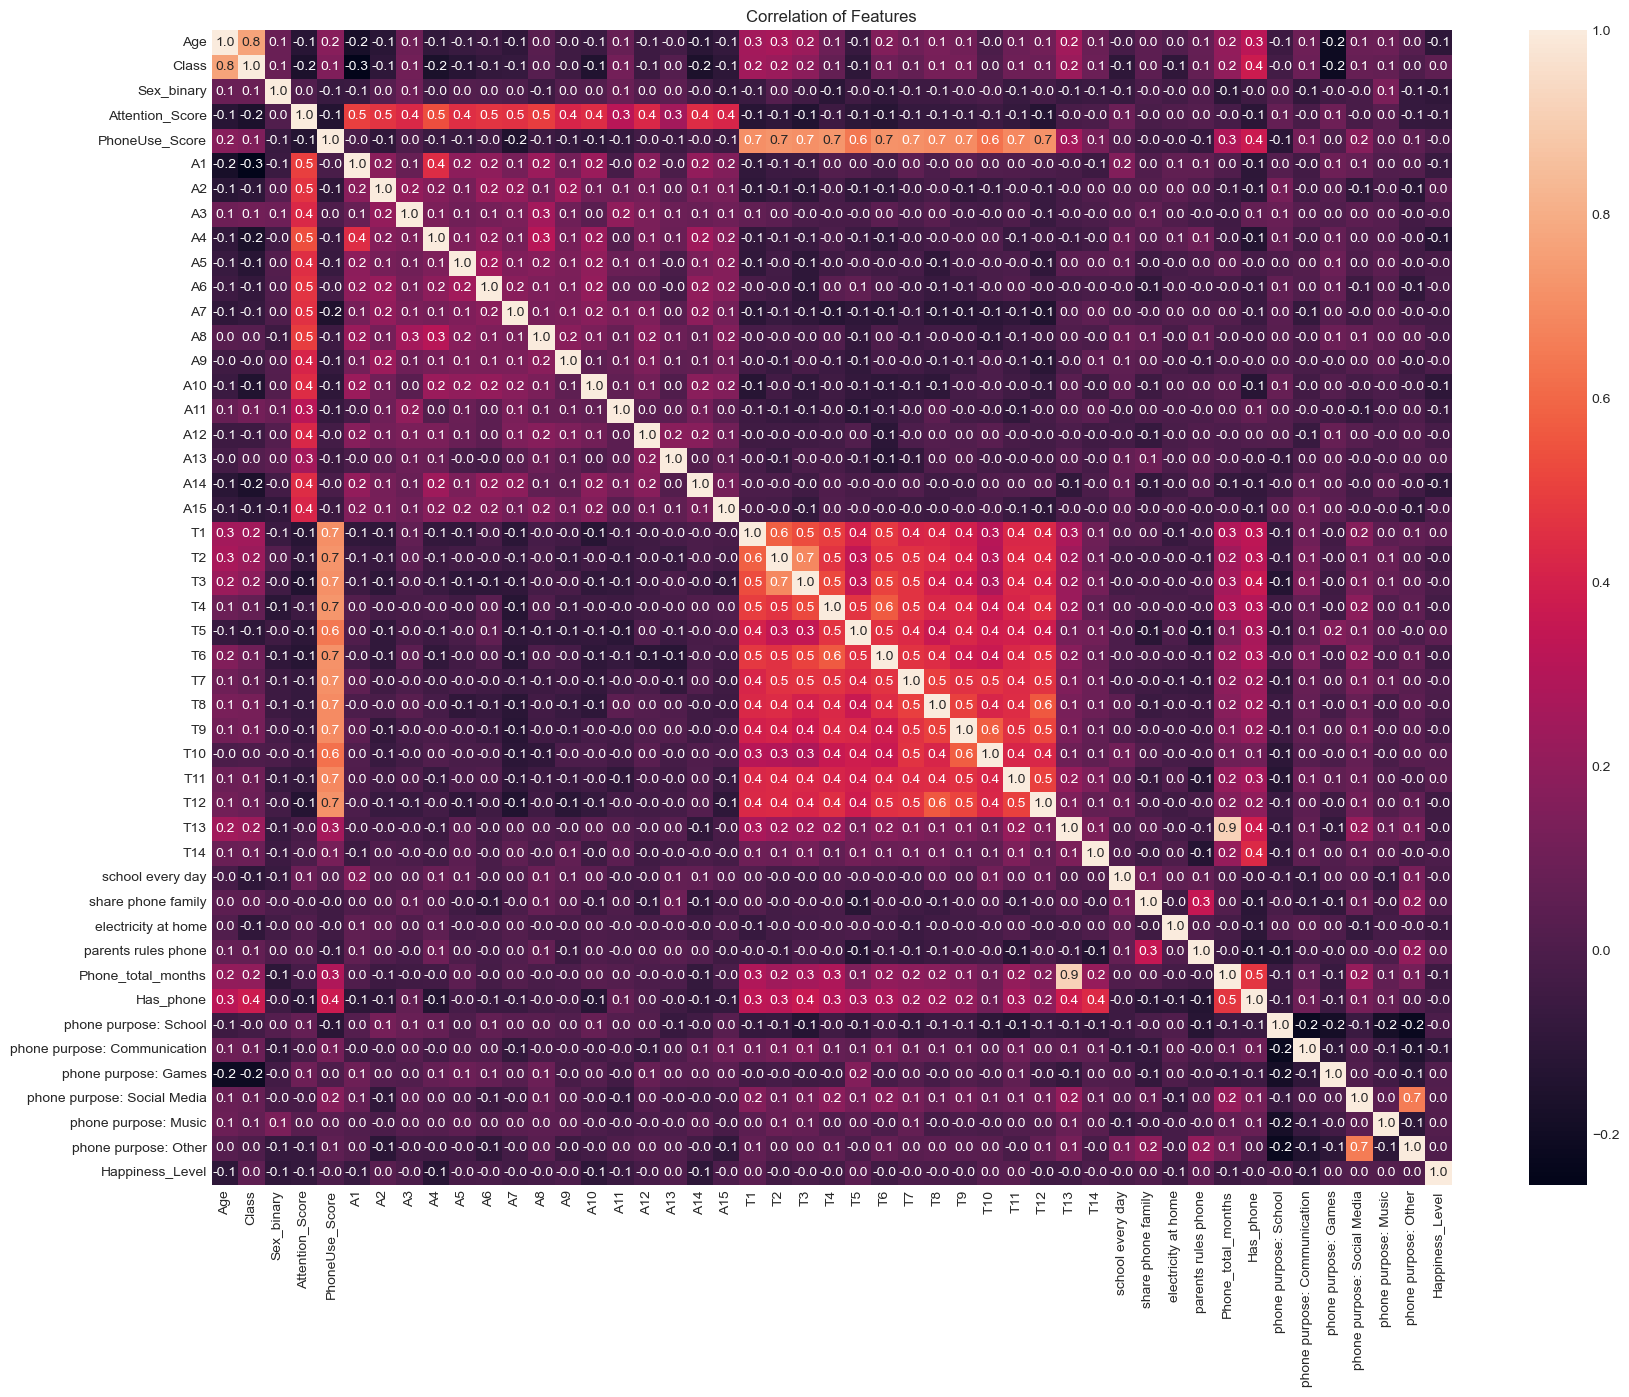


Top 10 features by correlation with target:
A4                              0.119063
A10                             0.102113
Age                             0.100362
A14                             0.099854
Sex_binary                      0.097295
phone purpose: Communication    0.081824
Attention_Score                 0.081631
A1                              0.068564
A11                             0.061012
electricity at home             0.051683
Name: Happiness_Level, dtype: float64


In [82]:
# Combine training features and target for correlation analysis
df_train = pd.concat([X_train, y_train.rename('Happiness_Level')], axis=1)

# Calculate correlation matrix
correlation_matrix = df_train.corr(numeric_only=True)

# 2) Correlation heatmap (optional)
plt.figure(figsize=(20, 15))
correlation_matrix = df_train.corr(numeric_only=True)
sns.heatmap(correlation_matrix, annot=True, fmt=".1f")
plt.title('Correlation of Features')
plt.show()

# Rank features by correlation with target
corr_with_target = correlation_matrix['Happiness_Level'].drop('Happiness_Level').abs().sort_values(ascending=False)
print("\nTop 10 features by correlation with target:")
print(corr_with_target.head(10))

In [83]:
# Use all available features (no feature selection)
X_train_sel = X_train.copy()
X_test_sel = X_test.copy()
selected_features = X_train.columns.tolist()

print(f"Using all {len(selected_features)} features:")
print(f"Training set shape: {X_train_sel.shape}")
print(f"Test set shape: {X_test_sel.shape}")

Using all 46 features:
Training set shape: (537, 46)
Test set shape: (135, 46)


## Model training 

In [84]:
# Train and evaluate baseline models
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
}

results = []

for name, model in models.items():
    # Train model
    model.fit(X_train_sel, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_sel)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })
    
    print(f"\n{'='*60}")
    print(f"{name}")
    print(f"{'='*60}")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")

# Create results dataframe
results_df = pd.DataFrame(results).sort_values('F1 Score', ascending=False)
print(f"\n{'='*60}")
print("Model Comparison (sorted by F1 Score)")
print(f"{'='*60}")
print(results_df.to_string(index=False))


Decision Tree
Accuracy:  0.4741
Precision: 0.3770
Recall:    0.4107
F1 Score:  0.3932

Random Forest
Accuracy:  0.6519
Precision: 0.6216
Recall:    0.4107
F1 Score:  0.4946

XGBoost
Accuracy:  0.5704
Precision: 0.4815
Recall:    0.4643
F1 Score:  0.4727

Model Comparison (sorted by F1 Score)
        Model  Accuracy  Precision   Recall  F1 Score
Random Forest  0.651852   0.621622 0.410714  0.494624
      XGBoost  0.570370   0.481481 0.464286  0.472727
Decision Tree  0.474074   0.377049 0.410714  0.393162


## Hyperparameter tuning

In [ ]:
# Hyperparameter tuning for Random Forest using RandomizedSearchCV
print("Performing hyperparameter tuning for Random Forest...")

# Define parameter grid
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
}

# Initialize model and cross-validation
rf = RandomForestClassifier(random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform randomized search
rf_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=rf_param_grid,
    n_iter=20,
    scoring='f1',
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf_search.fit(X_train_sel, y_train)

# Get best model
best_rf = rf_search.best_estimator_

print(f"\nBest parameters: {rf_search.best_params_}")
print(f"Best cross-validation F1 score: {rf_search.best_score_:.4f}")

# Evaluate on test set
y_pred_rf = best_rf.predict(X_test_sel)

print(f"\nTest Set Performance:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_rf):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred_rf):.4f}")

print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Low Happiness', 'High Happiness']))

Performing hyperparameter tuning for Random Forest...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


## Confusion Matrix

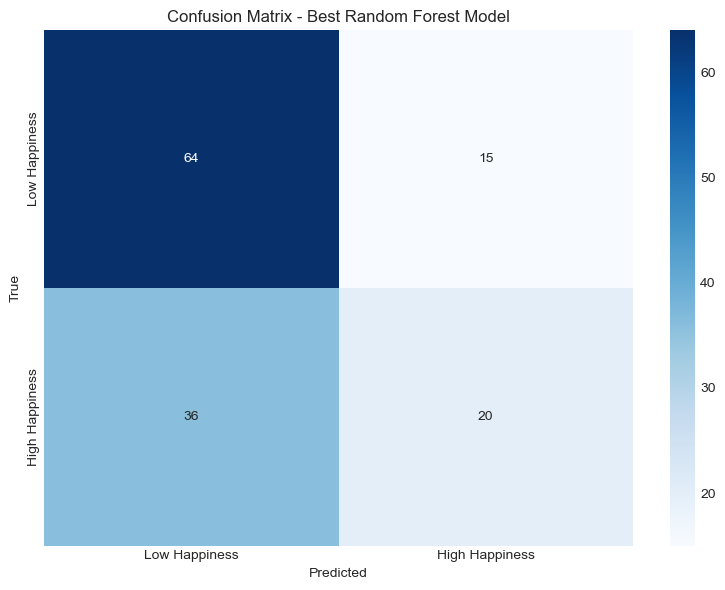


Confusion Matrix:
[[64 15]
 [36 20]]


In [ ]:
# Confusion matrix for best model
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Low Happiness', 'High Happiness'],
            yticklabels=['Low Happiness', 'High Happiness'])
plt.ylabel('True')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Best Random Forest Model')
plt.tight_layout()
plt.show()

print("\nConfusion Matrix:")
print(cm)

## SHAP


Accuracy: 0.5777777777777777


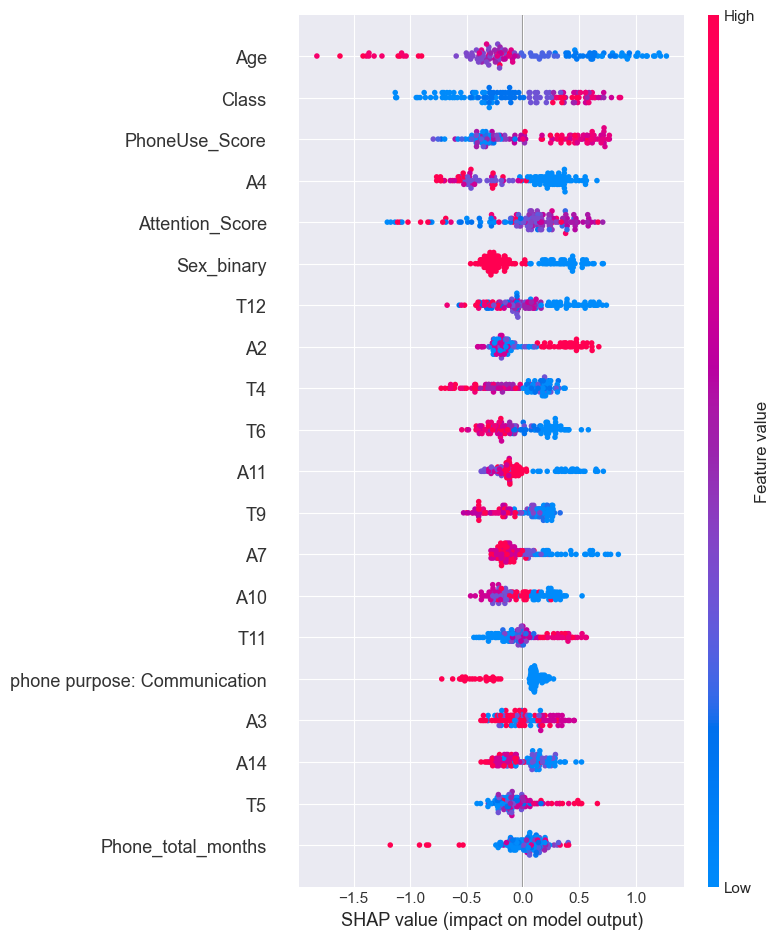

In [ ]:
clf = XGBClassifier(max_depth=3, n_estimators=100)

# Train Model
clf.fit(X_train, y_train)

# Classify new examples
y_pred= clf.predict(X_test_sel)
print("Accuracy:", accuracy_score(y_test, y_pred))

# Initialize the SHAP explainer
explainer = shap.Explainer(clf)
shap_values = explainer(X_test_sel)


# Plot the summary plot
shap.summary_plot(shap_values, X_test_sel)

## 9. Summary

### Key Findings:

1. **Data Processing**: Successfully processed multi-label phone purpose data and created binary happiness classification
2. **Feature Selection**: Selected top 20 features using ANOVA F-statistic
3. **Model Comparison**: Evaluated 7 different machine learning models
4. **Best Models**: XGBoost and Random Forest showed the best performance after hyperparameter tuning
5. **Interpretability**: SHAP analysis revealed the most influential features for happiness prediction

### Next Steps:

- Collect more data to improve model performance